<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/Day_Trading_Strategy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [445]:
#!pip3 install pyfolio
import pyfolio as pyf

**DAY TRADING STRATEGY**

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [446]:
# For data manupulations

START = '2021-08-03'
END = '2023-08-03'

VOLATILITY_FACTOR = 0.45
LOOKBACK = 45
R_WINDOW = 45
REVERSED = True
LEFT, RIGHT = datetime.date(2021, 1, 1), datetime.date(2023, 8, 3)

# VF    LB    PEAK_CUM  CUM_LAST    REVERSED
# 0.25  45    6.11       4.29 OK    True
# 0.35  45    7.42       5.02 OK    True
# 0.40  45    7.64       5.17 OK    True
# 0.45  45    8.99       6.16 OK    True
# 0.45  45    1.22       1.05 OK    False
# 0.45  55    7.97       5.39 OK    True
# 0.45  25    2.51       1.66
# 0.45  65    4.05       2.59
# 0.45  90    4.3        2.7
# 0.50  45    4.34       3.02
# 0.55  45    3.84       2.67
# 1.00  45    3.76       2.62

import pandas as pd
import numpy as np
import yfinance as yf

# For plotting
import matplotlib.pyplot as plt

Ticker = "CANTE"
# Read data from Yahoo finance
TickerIS = Ticker + ".IS"
data = yf.download(TickerIS,START, END)

data_close = data['Adj Close']
# Convert index into datetime format
data.index = pd.to_datetime(data.index,format="%d-%m-%Y")

# Calculate adjustment factor
adjusted_factor = data['Adj Close'] / data['Close']

# Calculate adjusted open price
data['Adj Open'] = adjusted_factor * data['Open']

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Open
Date,,,,,,,
2023-07-27,17.400000,19.400000,16.530001,18.700001,18.700001,328539386,17.400000
2023-07-28,18.770000,19.969999,18.450001,19.700001,19.700001,143406886,18.770000
2023-07-31,20.000000,21.639999,19.900000,21.540001,21.540001,113910433,20.000000
2023-08-01,21.879999,22.180000,20.299999,20.740000,20.740000,133059984,21.879999
2023-08-02,20.740000,21.320000,19.950001,20.420000,20.420000,105850527,20.740000


In [447]:
# Calculate returns
data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

In [448]:
# Calculate standard deviation of returns
data['std'] = data['returns'].rolling(R_WINDOW).std()

In [449]:
data['positions'] = np.nan

In [450]:
# GAP UP-GAP DOWN STRATEGY

# Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [451]:
# # IMPROVED STRATEGY

# Long entry condition
if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
else:
# Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']






In [452]:
# Store 1 when long entry condition is true
data.loc[long_entry, 'positions'] = 1

# Store -1 when short entry condition is true
# data.loc[short_entry, 'positions'] = -1

# Store 0 when wait condition is true
data.loc[short_entry, 'positions'] = 0

data['positions'].fillna(method='ffill', inplace=True)

# Drop NaN values
#data = data.dropna()

In [453]:
data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions

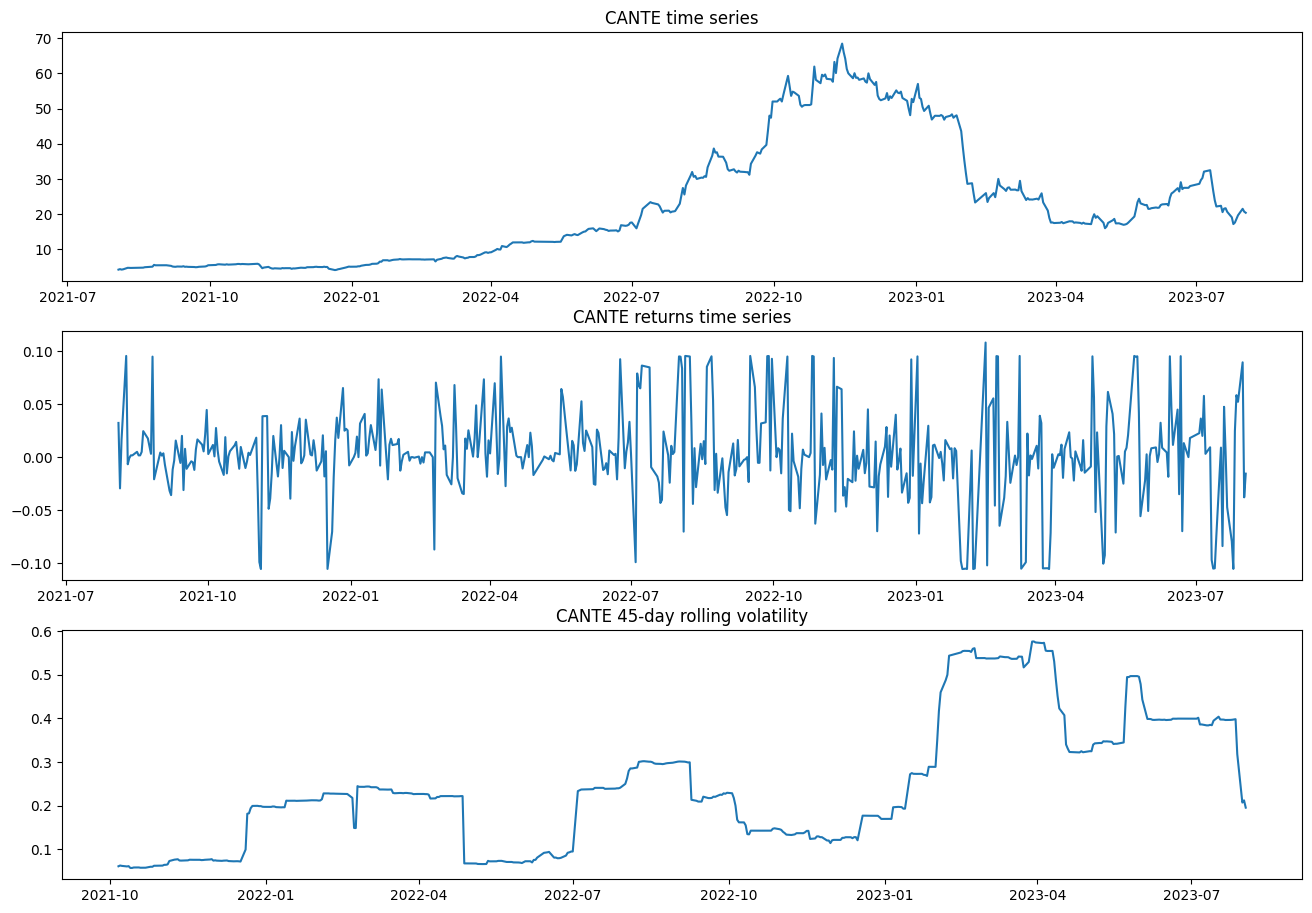

In [454]:
plt.subplot(3, 1, 1)
plt.plot(data_close)
plt.title(f"{Ticker} time series")

data_log_returns = data_close.pct_change().apply(lambda x: np.log(1+x))

plt.subplot(3, 1, 2)
plt.plot(data_log_returns)
plt.title(f"{Ticker} returns time series")

plt.subplot(3, 1, 3)
data_vlt = data_close.rolling(R_WINDOW).std()*(252**0.5)

plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.plot(data['std']*252**0.5)

fig = plt.gcf()
fig.set_size_inches(16, 11)
plt.show()

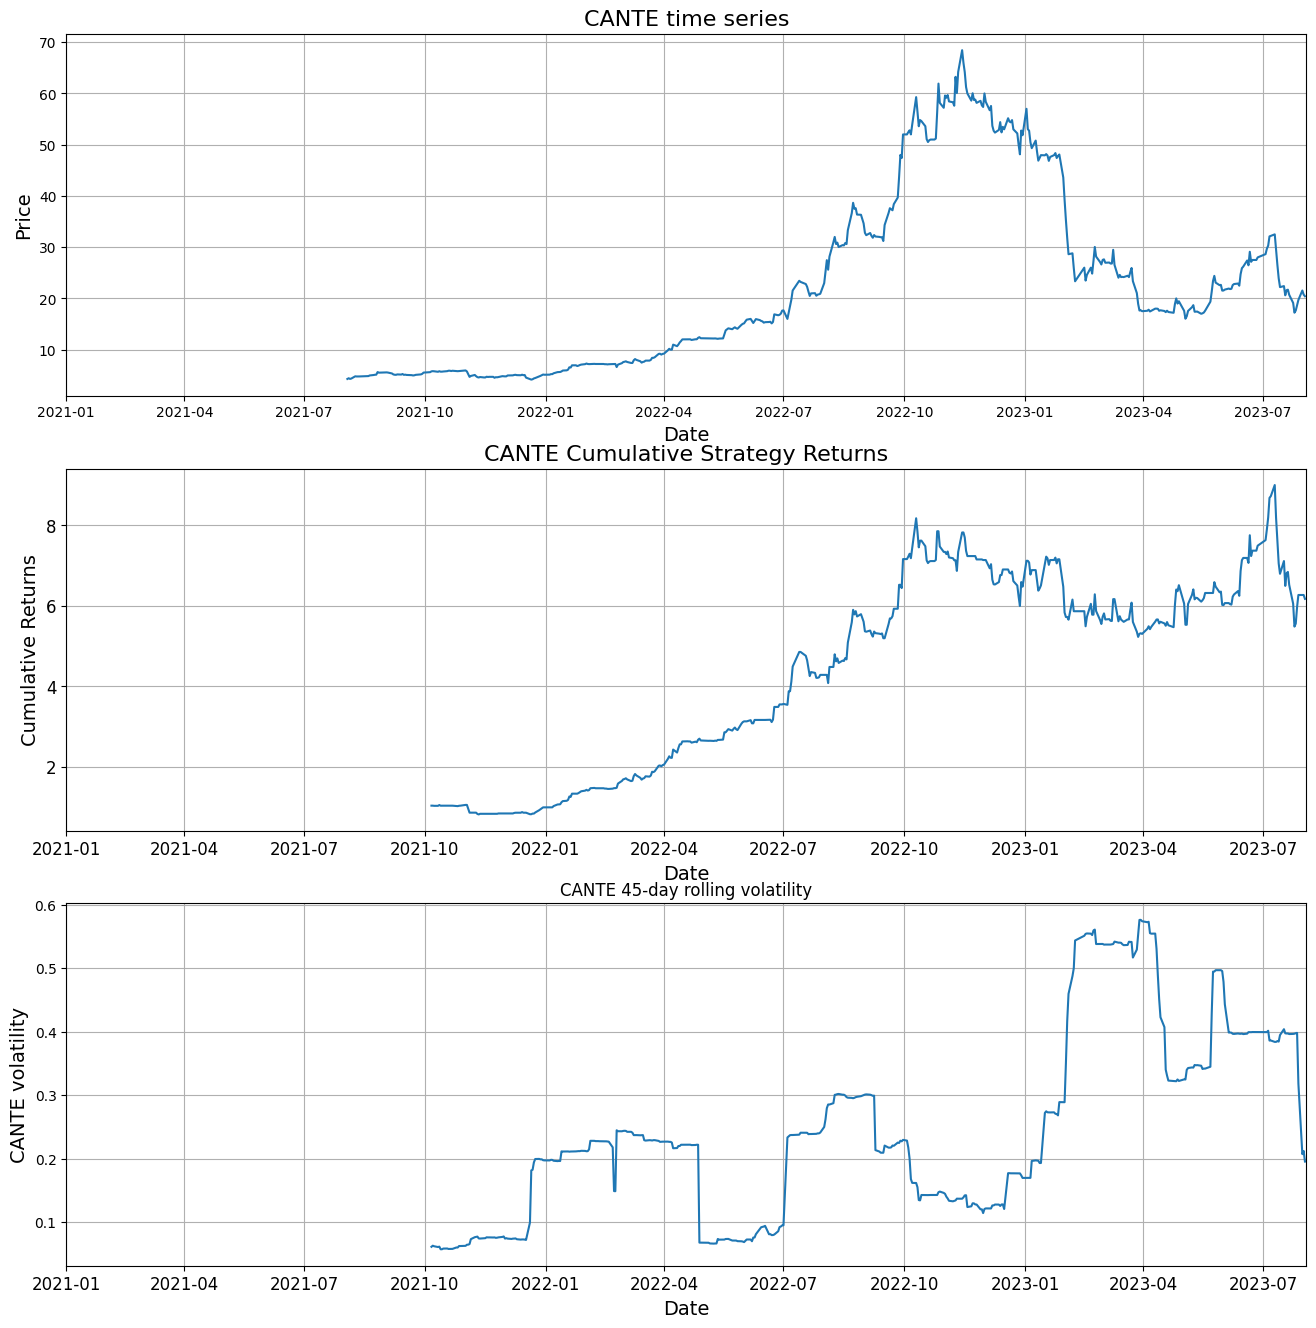

In [455]:
# Plot cumulative returns

import datetime

plt.figure(figsize=(14,11))

plt.subplot(3, 1, 1)
plt.xlim(LEFT, RIGHT)
plt.plot(data_close)
plt.title(f"{Ticker} time series", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid()

plt.subplot(3, 1, 2)
plt.xlim(LEFT, RIGHT)
data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()
#data['cumulative_strategy_returns'].fillna(method='ffill', inplace=True)

plt.plot(data.cumulative_strategy_returns)
plt.title(f"{Ticker} returns time series")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Strategy Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(3, 1, 3)
plt.xlim(LEFT, RIGHT)
plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.xlabel('Date', fontsize=14)
plt.ylabel(f'{Ticker} volatility', fontsize=14)
plt.grid()
plt.xticks(fontsize=12)

plt.plot(data['std']*252**0.5)
fig = plt.gcf()
fig.set_size_inches(16, 16)


plt.show()

In [456]:
data.loc['2022-11-01':'2022-12-30']

,Open,High,Low,Close,Adj Close,Volume,Adj Open,returns,std,positions,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,
2022-11-01,57.599998,60.360001,55.200001,59.599998,59.599998,1131347,57.599998,0.006993,0.009090,0.0,0.000000,7.333403
2022-11-02,59.599998,62.400002,57.119999,59.160000,59.160000,1149502,59.599998,0.000000,0.008812,1.0,-0.007383,7.279264
2022-11-03,59.160000,61.200001,57.959999,59.680000,59.680000,941992,59.160000,0.000000,0.008633,1.0,0.008790,7.343246
2022-11-04,59.639999,60.200001,58.400002,58.439999,58.439999,626217,59.639999,-0.000670,0.008403,1.0,-0.020121,7.195495
2022-11-07,58.439999,59.880001,57.080002,58.279999,58.279999,584740,58.439999,0.000000,0.008350,1.0,-0.002738,7.175795
2022-11-08,58.000000,58.840000,56.959999,57.599998,57.599998,445780,58.000000,-0.004804,0.008392,1.0,-0.006897,7.126306
2022-11-09,58.000000,63.360001,58.000000,63.240002,63.240002,1976265,58.000000,0.006944,0.008440,0.0,0.000000,7.126306
2022-11-10,62.400002,62.759998,59.360001,60.080002,60.080002,1223772,62.400002,-0.013283,0.008614,1.0,-0.037179,6.861354
2022-11-11,60.080002,65.480003,58.720001,64.199997,64.199997,2217552,60.080002,0.000000,0.008609,1.0,0.068575,7.331872


/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2021-10-06
End date,2023-08-02
Total months,21
,Backtest
Annual return,172.7%
Cumulative returns,516.6%
Annual volatility,54.5%
Sharpe ratio,2.11
Calmar ratio,4.41
Stability,0.80
Max drawdown,-39.1%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


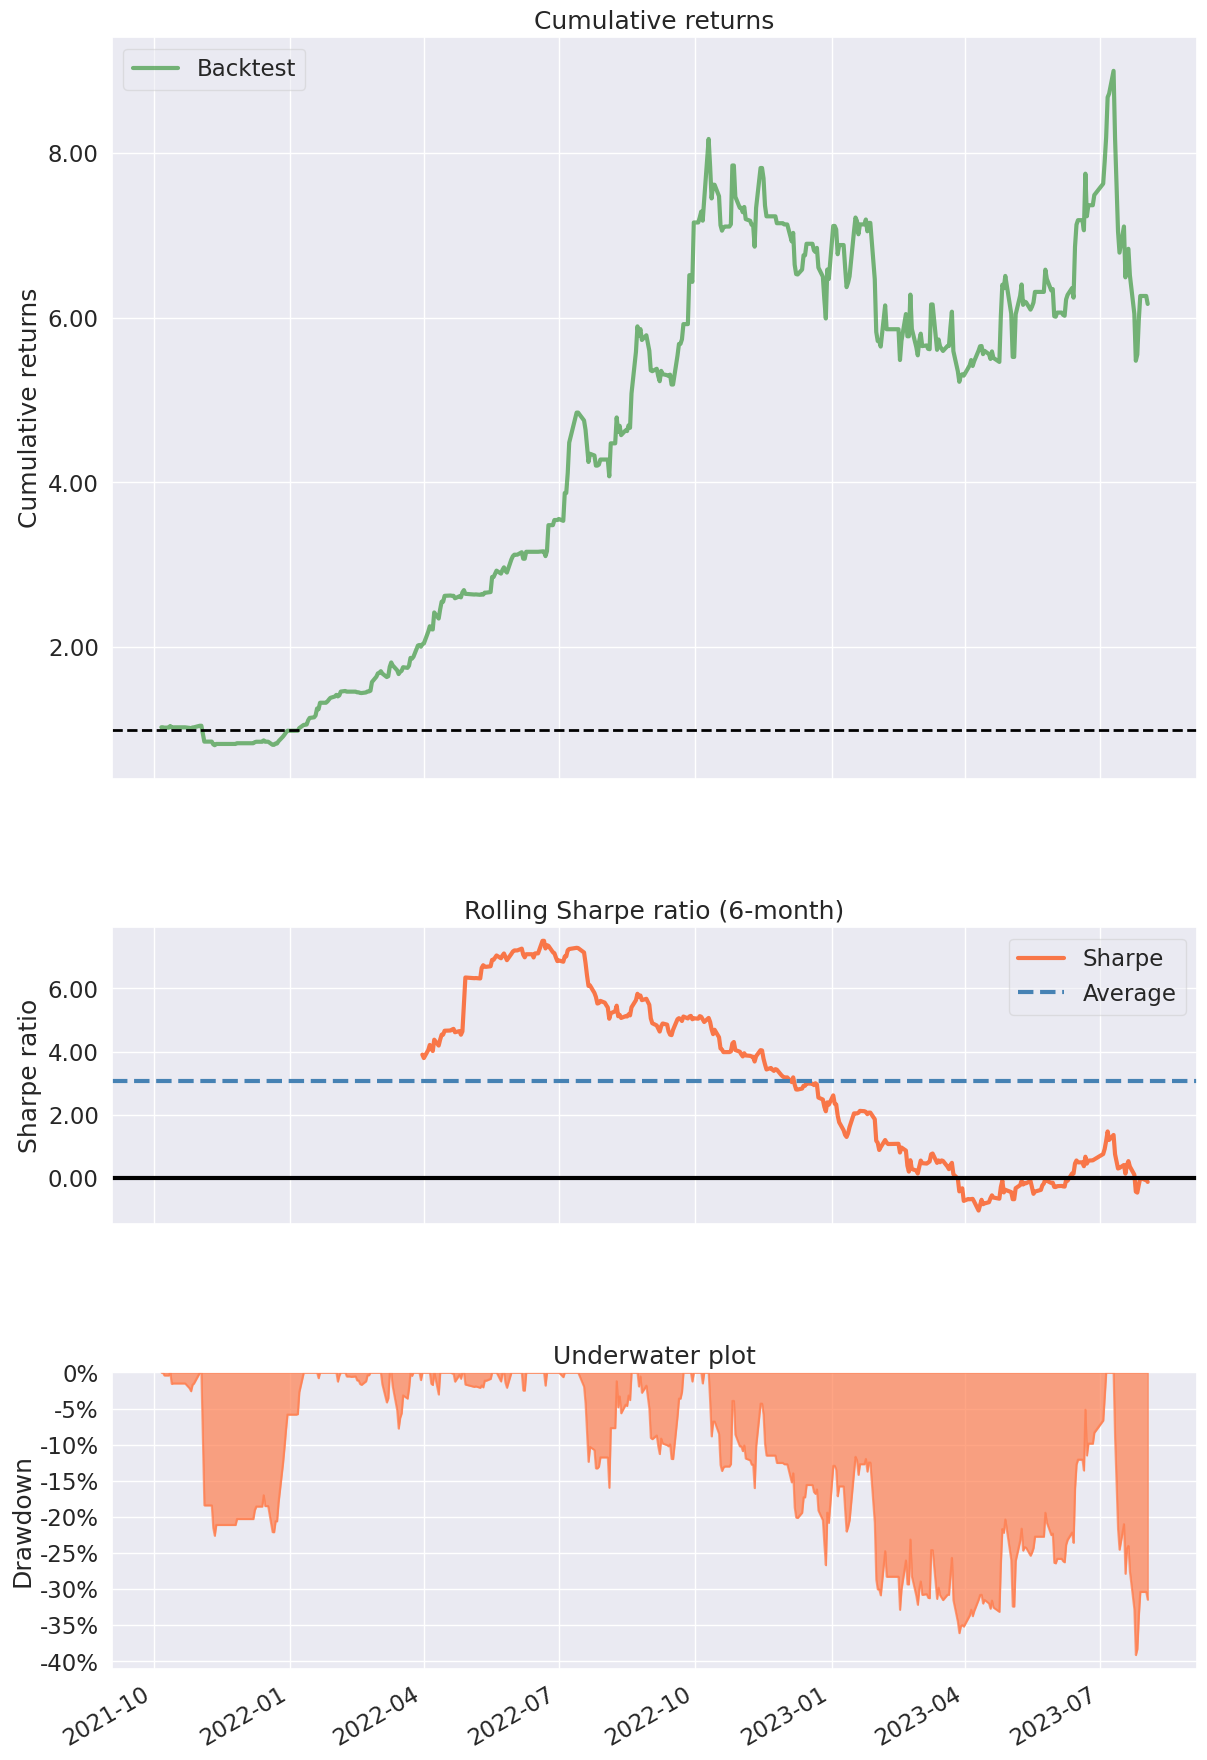

In [457]:
pyf.create_simple_tear_sheet(data.strategy_returns.dropna())

In [458]:
np.max(data.cumulative_strategy_returns)

8.995285958907877

In [459]:
(data.cumulative_strategy_returns[-1])

6.166103836709427